# ART - Adversarial Patch Attack on YOLOv8 (Tank Dataset)

이 노트북은 커스텀 Tank 데이터셋에 대해 YOLOv8 모델을 사용한 적대적 패치 공격을 시연합니다.

**기반 코드**: ART 공식 예제 `attack_adversarial_patch_pytorch_yolo.ipynb`  
**모델**: YOLOv8n with PyTorchYoloLossWrapper  
**데이터셋**: Custom Tank Detection Dataset

## 1. 환경 설정 및 임포트

In [37]:
import os
import sys
import numpy as np
import torch
import cv2
import yaml
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

# Ultralytics YOLO
from ultralytics import YOLO

# ART imports
from art.estimators.object_detection import PyTorchYolo
# PyTorchYoloLossWrapper는 직접 임포트할 필요 없음 (PyTorchYolo가 자동 적용)
from art.attacks.evasion import AdversarialPatchPyTorch, RobustDPatch

# Matplotlib 설정
plt.style.use('ggplot')
%matplotlib inline

# CUDA 정보
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5080
Using device: cuda


## 2. 데이터셋 설정

In [38]:
# 경로 설정import osfrom pathlib import Path# Get current notebook directorytry:    CURRENT_DIR = Path(globals()['_dh'][0]) if '_dh' in globals() else Path(os.getcwd())except:    CURRENT_DIR = Path(os.getcwd())# Navigate to project root# Current: art_training/attacks/ -> Project root: ../..PROJECT_ROOT = CURRENT_DIR.parent.parent# Model paths relative to project root  DATA_YAML = PROJECT_ROOT / "merged_dataset" / "data.yaml"MODEL_PATH = PROJECT_ROOT / "tank.yolo8" / "runs" / "detect" / "train_with_coco" / "weights" / "best.pt"# data.yaml 로드with open(DATA_YAML, 'r') as f:    data_config = yaml.safe_load(f)print("Dataset configuration:")print(f"  Number of classes: {data_config['nc']}")print(f"  Class names: {data_config['names']}")print(f"  Training images: {data_config['train']}")print(f"  Validation images: {data_config['val']}")# 클래스 이름 (COCO 형식 대신 Tank 데이터셋)CLASS_NAMES = data_config['names']

Dataset configuration:
  Number of classes: 81
  Class names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse

## 3. 유틸리티 함수

In [39]:
def extract_predictions(predictions, conf_thresh=0.5):
    """예측 결과에서 신뢰도 임계값 이상의 탐지만 추출"""
    if not isinstance(predictions, dict):
        return [], [], []
    
    # 신뢰도 점수로 먼저 필터링
    predictions_score = list(predictions["scores"])
    predictions_t = [i for i, x in enumerate(predictions_score) if x > conf_thresh]
    
    if len(predictions_t) == 0:
        return [], [], []
    
    # 필터링된 예측 결과
    predictions_boxes = [[(predictions["boxes"][i][0], predictions["boxes"][i][1]), 
                          (predictions["boxes"][i][2], predictions["boxes"][i][3])] 
                         for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    
    # 클래스 이름 가져오기 (안전하게 처리)
    predictions_class = []
    for i in predictions_t:
        label_idx = int(predictions["labels"][i])
        # 인덱스가 범위를 벗어나면 기본 클래스명 사용
        if 0 <= label_idx < len(CLASS_NAMES):
            predictions_class.append(CLASS_NAMES[label_idx])
        else:
            # 범위를 벗어난 경우 첫 번째 클래스로 매핑 (Tank 데이터셋은 클래스가 하나)
            predictions_class.append(CLASS_NAMES[0])
    
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, pred_scores=None, title="Detection"):
    """이미지에 바운딩 박스와 클래스 레이블을 그립니다."""
    text_size = 0.8
    text_th = 2
    rect_th = 2
    
    # 이미지 복사
    img_display = img.copy()
    
    for i in range(len(boxes)):
        # 바운딩 박스 그리기
        cv2.rectangle(
            img_display, 
            (int(boxes[i][0][0]), int(boxes[i][0][1])), 
            (int(boxes[i][1][0]), int(boxes[i][1][1])),
            color=(0, 255, 0), 
            thickness=rect_th
        )
        
        # 클래스 레이블 및 신뢰도 텍스트
        if pred_scores:
            label = f"{pred_cls[i]}: {pred_scores[i]:.2f}"
        else:
            label = pred_cls[i]
        
        cv2.putText(
            img_display, 
            label, 
            (int(boxes[i][0][0]), int(boxes[i][0][1]) - 5), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            text_size,
            (0, 255, 0), 
            thickness=text_th
        )
    
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(title, fontsize=14, weight='bold')
    plt.imshow(img_display.astype(np.uint8), interpolation="nearest")
    plt.show()


def filter_boxes(predictions, conf_thresh=0.5):
    """신뢰도 임계값으로 예측 필터링 (ART 형식)"""
    dictionary = {}
    
    boxes_list = []
    scores_list = []
    labels_list = []
    
    for i in range(len(predictions["boxes"])):
        score = predictions["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions["boxes"][i])
            scores_list.append(predictions["scores"][i])
            labels_list.append(predictions["labels"][i])
    
    if len(boxes_list) == 0:
        dictionary["boxes"] = np.array([], dtype=np.float32).reshape(0, 4)
        dictionary["scores"] = np.array([], dtype=np.float32)
        dictionary["labels"] = np.array([], dtype=np.int64)
    else:
        dictionary["boxes"] = np.vstack(boxes_list)
        dictionary["scores"] = np.hstack(scores_list)
        dictionary["labels"] = np.hstack(labels_list)
    
    return dictionary

## 4. 데이터 로드

In [40]:
def load_images_from_directory(image_dir, num_images=10, img_size=640):
    """디렉토리에서 이미지 로드"""
    image_dir = Path(image_dir).resolve()
    
    # 이미지 파일 검색
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG', '*.png', '*.PNG']:
        image_files.extend(list(image_dir.glob(ext)))
    
    if len(image_files) == 0:
        print(f"Warning: No images found in {image_dir}")
        return np.array([]), []
    
    image_files = sorted(image_files)[:num_images]
    
    images = []
    for img_path in tqdm(image_files, desc="Loading images"):
        # PIL로 이미지 로드
        img = Image.open(img_path).convert('RGB')
        # 리사이즈 (640x640)
        img = img.resize((img_size, img_size), Image.BICUBIC)
        # numpy 배열로 변환 (H, W, C)
        img_array = np.array(img)
        # (C, H, W) 형식으로 변환
        img_array = img_array.transpose(2, 0, 1)
        images.append(img_array)
    
    # [0, 255] 범위로 유지 (YOLOv8은 0-255 사용)
    return np.array(images, dtype=np.float32), [str(p) for p in image_files]


# 테스트 데이터 로드 (test 디렉토리 사용)
data_yaml_dir = Path(DATA_YAML).parent.resolve()

tank_images = None
image_paths = None

print("Searching for Tank images in test directory...")

# test 디렉토리에서 이미지 로드
test_paths = [
    data_yaml_dir / "test" / "images",
]

for path in test_paths:
    print(f"Trying: {path}")
    if path.exists():
        tank_images, image_paths = load_images_from_directory(path)
        if len(tank_images) > 0:
            print(f"\n✓ Loaded {len(tank_images)} images from {path}")
            break

if tank_images is None or len(tank_images) == 0:
    raise ValueError("No images found! Please check the data paths.")

print(f"\nImage shape: {tank_images.shape}")
print(f"Value range: [{tank_images.min():.1f}, {tank_images.max():.1f}]")

Searching for Tank images in test directory...
Trying: /home/jaehyun/yolo_train/merged_dataset/test/images


Loading images: 100%|██████████| 10/10 [00:00<00:00, 740.82it/s]


✓ Loaded 10 images from /home/jaehyun/yolo_train/merged_dataset/test/images

Image shape: (10, 3, 640, 640)
Value range: [0.0, 255.0]


## 5. YOLOv8 모델 설정 (PyTorchYoloLossWrapper 사용)

In [41]:
# YOLOv8 모델 로드
print(f"Loading YOLOv8 model from {MODEL_PATH}")
yolo_base = YOLO(MODEL_PATH)
model = yolo_base.model

# 모델을 디바이스로 이동 (PyTorchYolo가 자동으로 래핑함)
model.to(device)
model.train()  # 학습 모드 (gradient 계산 필요)

print(f"Model loaded and moved to {device}")
print(f"Model in training mode: {model.training}")

Loading YOLOv8 model from /home/jaehyun/yolo_train/tank.yolo8/runs/detect/train_with_coco/weights/best.pt
Model loaded and moved to cuda
Model in training mode: True


In [42]:
# ART PyTorchYolo Estimator 생성
INPUT_SHAPE = (3, 640, 640)

detector = PyTorchYolo(
    model=model,  # 원본 모델 전달 (is_ultralytics=True이면 자동으로 래핑됨)
    device_type='cuda' if torch.cuda.is_available() else 'cpu',
    input_shape=INPUT_SHAPE,
    clip_values=(0, 255),  # YOLOv8은 [0, 255] 범위 사용
    channels_first=True,
    attack_losses=("loss_total", "loss_cls", "loss_box", "loss_dfl"),  # YOLOv8 loss components
    is_ultralytics=True,  # 자동으로 PyTorchYoloLossWrapper 적용
    model_name="yolov8n"
)

print("ART PyTorchYolo Estimator created successfully!")
print(f"  Input shape: {detector.input_shape}")
print(f"  Clip values: {detector.clip_values}")
print(f"  Attack losses: {detector.attack_losses}")

ART PyTorchYolo Estimator created successfully!
  Input shape: (3, 640, 640)
  Clip values: [          0         255]
  Attack losses: ('loss_total', 'loss_cls', 'loss_box', 'loss_dfl')


## 6. 원본 이미지에 대한 탐지 결과

In [43]:
# 원본 이미지 예측
print("Running predictions on original images...")
dets = detector.predict(tank_images)

print(f"\nPredictions for {len(dets)} images:")
for i, det in enumerate(dets):
    num_detections = len(det['boxes'])
    print(f"  Image {i+1}: {num_detections} detections")

Running predictions on original images...

Predictions for 10 images:
  Image 1: 1 detections
  Image 2: 1 detections
  Image 3: 1 detections
  Image 4: 5 detections
  Image 5: 4 detections
  Image 6: 9 detections
  Image 7: 1 detections
  Image 8: 1 detections
  Image 9: 6 detections
  Image 10: 1 detections


Visualizing original detections...


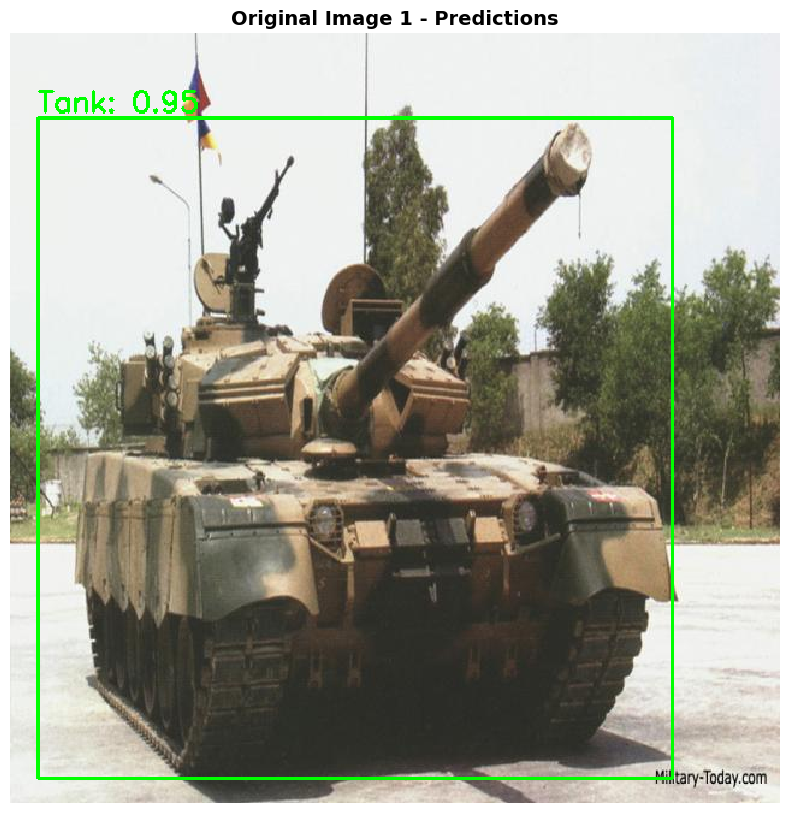

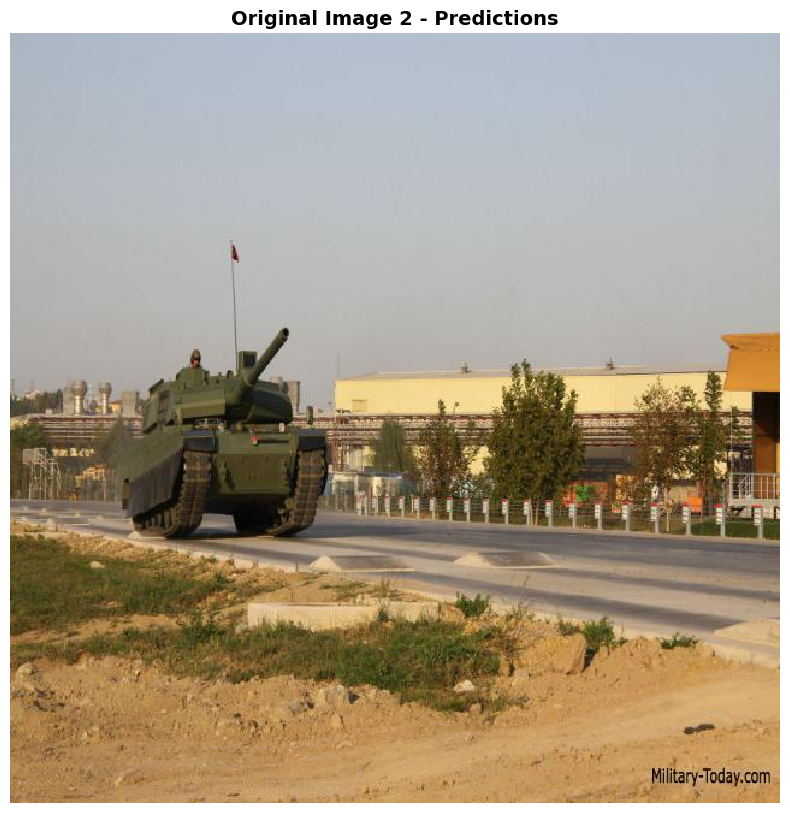

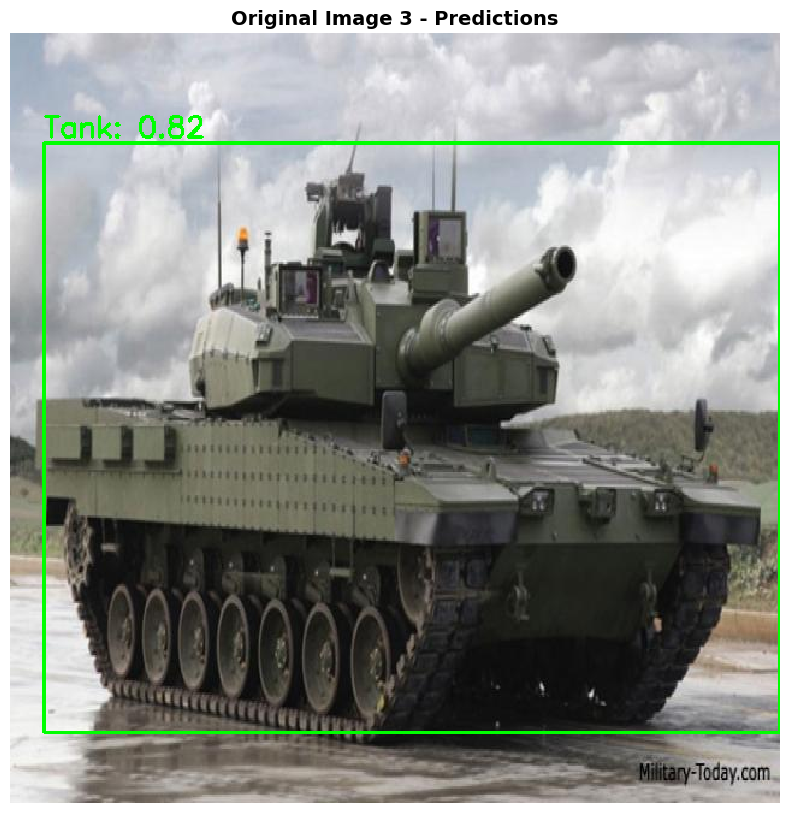

In [44]:
# 원본 이미지 탐지 결과 시각화
print("Visualizing original detections...")

for i in range(min(3, len(dets))):
    preds_orig = extract_predictions(dets[i], conf_thresh=0.5)
    img_display = tank_images[i].transpose(1, 2, 0).copy()
    plot_image_with_boxes(
        img=img_display, 
        boxes=preds_orig[1], 
        pred_cls=preds_orig[0],
        pred_scores=preds_orig[2],
        title=f"Original Image {i+1} - Predictions"
    )

## 7. 적대적 패치 공격 설정

In [ ]:
# 공격 파라미터
rotation_max = 22.5  # 최대 회전 각도
scale_min = 0.2      # 최소 스케일
scale_max = 0.4      # 최대 스케일
distortion_scale_max = 0.0  # 왜곡 (0 = 비활성화)
learning_rate = 5.0  # 학습률
max_iter = 500       # 최대 반복 횟수
batch_size = 1       # 배치 크기 (이미지마다 타겟 박스 개수가 다르므로 1로 설정)
patch_shape = (3, 200, 200)  # 패치 크기 (C, H, W)
patch_type = "circle"  # 패치 형태: "circle" or "square"
optimizer = "Adam"   # 옵티마이저: "Adam" or "pgd"

print("Adversarial Patch Attack Parameters:")
print(f"  Rotation max: {rotation_max}°")
print(f"  Scale range: [{scale_min}, {scale_max}]")
print(f"  Learning rate: {learning_rate}")
print(f"  Max iterations: {max_iter}")
print(f"  Batch size: {batch_size} (required for variable targets)")
print(f"  Patch shape: {patch_shape}")
print(f"  Patch type: {patch_type}")

## 8. 타겟 레이블 준비

**Untargeted Attack**: 탱크 탐지를 회피 (y = 원본 탐지 결과)  
**Targeted Attack**: 다른 클래스로 오분류 유도 (예: 이 예제에서는 untargeted 사용)

In [46]:
# 타겟 레이블 필터링 (신뢰도 임계값 적용)
y_target = [filter_boxes(det, conf_thresh=0.5) for det in dets]

print(f"Target labels prepared for {len(y_target)} images")
for i, y in enumerate(y_target[:3]):
    print(f"  Image {i+1}: {len(y['boxes'])} target boxes")

Target labels prepared for 10 images
  Image 1: 1 target boxes
  Image 2: 0 target boxes
  Image 3: 1 target boxes


## 9. 적대적 패치 생성 (AdversarialPatchPyTorch)

In [ ]:
# AdversarialPatchPyTorch 공격 객체 생성
# 배치 크기를 1로 설정하여 텐서 크기 불일치 문제 해결
ap_attack = AdversarialPatchPyTorch(
    estimator=detector,
    rotation_max=rotation_max,
    scale_min=scale_min,
    scale_max=scale_max,
    distortion_scale_max=distortion_scale_max,
    learning_rate=learning_rate,
    max_iter=max_iter,
    batch_size=1,  # 배치 크기를 1로 설정 (타겟 박스 개수가 이미지마다 다름)
    patch_shape=patch_shape,
    patch_type=patch_type,
    optimizer=optimizer,
    targeted=False,  # Untargeted: 탐지 회피
    verbose=True
)

print("AdversarialPatchPyTorch attack created!")
print(f"  Batch size: 1 (to handle variable number of targets per image)")

In [ ]:
# 적대적 패치 생성 (시간이 오래 걸림)
print(f"\nGenerating adversarial patch...")
print(f"This may take several minutes (max_iter={max_iter})...\n")

# 참고: batch_size=1로 설정했으므로 이미지 개수가 많을수록 시간이 오래 걸립니다
# 테스트 시에는 일부 이미지만 사용 권장: tank_images[:5]

try:
    patch, patch_mask = ap_attack.generate(
        x=tank_images,  # 모든 이미지 사용 (또는 [:5]로 5개만)
        y=y_target
    )
    
    print(f"\n✓ Adversarial patch generated!")
    print(f"Patch shape: {patch.shape}")
    print(f"Patch value range: [{patch.min():.1f}, {patch.max():.1f}]")
    
except RuntimeError as e:
    print(f"\n✗ Error during patch generation: {e}")
    print("\nTroubleshooting tips:")
    print("1. Reduce batch_size to 1 (already done)")
    print("2. Reduce number of images (use tank_images[:5])")
    print("3. Reduce max_iter for faster testing")
    print("4. Check if targets have consistent format")
    raise

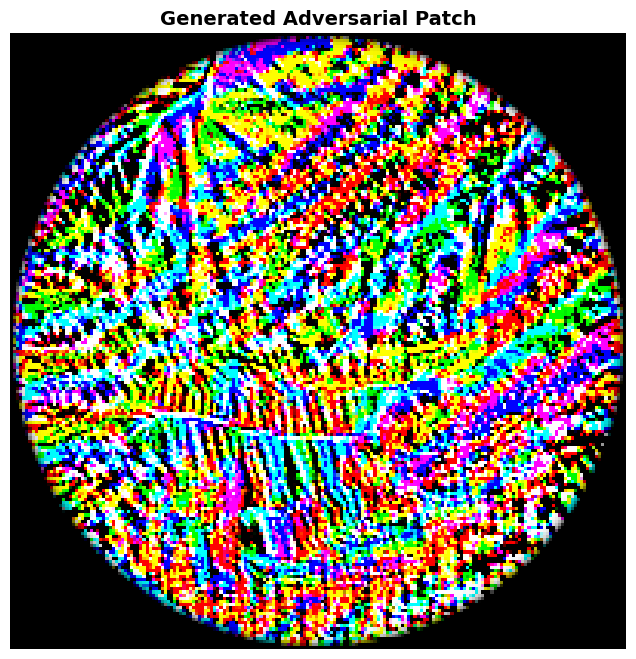

In [ ]:
# 생성된 패치 시각화
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Adversarial Patch", fontsize=14, weight='bold')
# 패치 마스크 적용 후 시각화
patch_display = (patch * patch_mask).transpose(1, 2, 0).astype(np.uint8)
plt.imshow(patch_display)
plt.show()

## 10. 패치가 적용된 이미지 생성 및 평가

In [ ]:
# 패치를 이미지에 적용
print("Applying patch to images...")
patched_images = ap_attack.apply_patch(tank_images, scale=0.3)

print(f"Patched images shape: {patched_images.shape}")
print(f"Value range: [{patched_images.min():.1f}, {patched_images.max():.1f}]")

Applying patch to images...
Patched images shape: (10, 3, 640, 640)
Value range: [0.0, 255.0]


In [ ]:
# 패치가 적용된 이미지에 대한 탐지
print("\nRunning predictions on patched images...")
dets_patched = detector.predict(patched_images)

print(f"\nPredictions comparison:")
for i in range(len(dets)):
    orig_count = len(dets[i]['boxes'])
    patched_count = len(dets_patched[i]['boxes'])
    print(f"  Image {i+1}:")
    print(f"    Original: {orig_count} detections")
    print(f"    Patched: {patched_count} detections")
    print(f"    Reduction: {orig_count - patched_count}")


Running predictions on patched images...

Predictions comparison:
  Image 1:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 2:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 3:
    Original: 1 detections
    Patched: 3 detections
    Reduction: -2
  Image 4:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 5:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 6:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 7:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 8:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 9:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0
  Image 10:
    Original: 1 detections
    Patched: 1 detections
    Reduction: 0


Visualizing patched image detections...


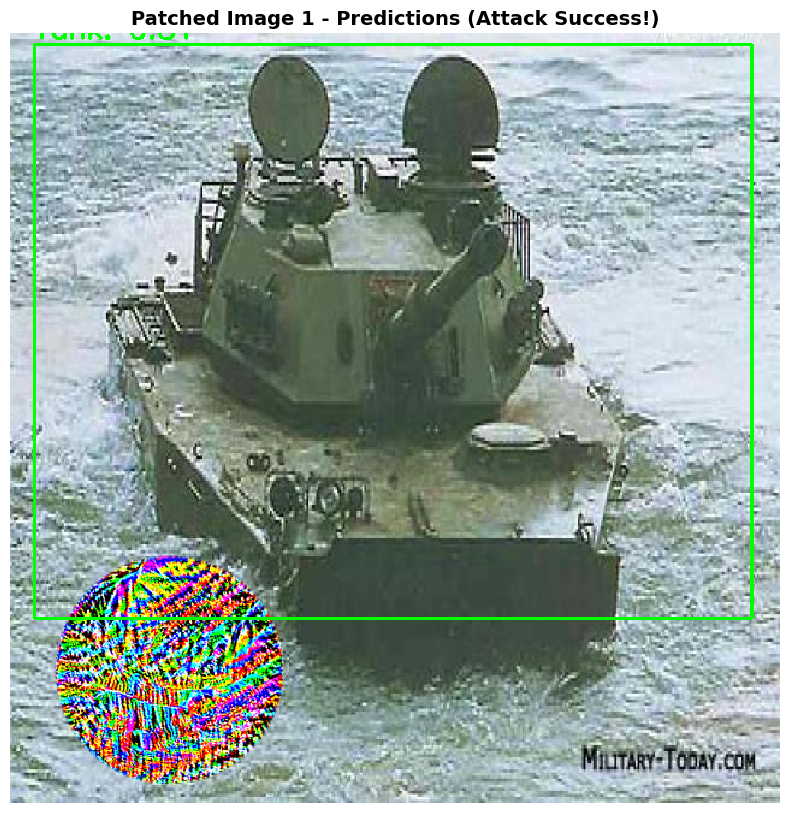

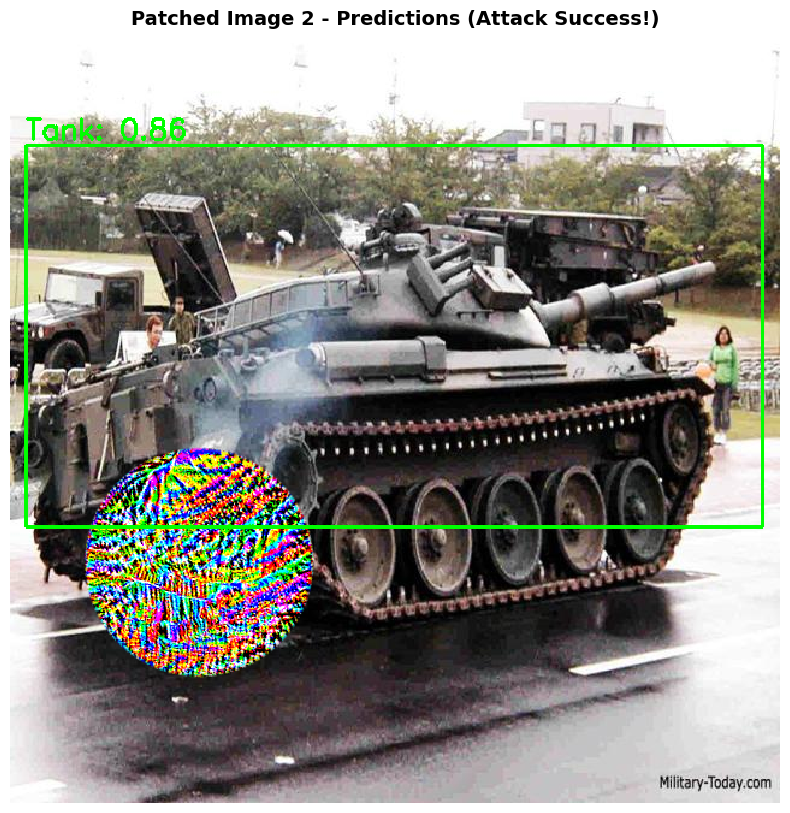

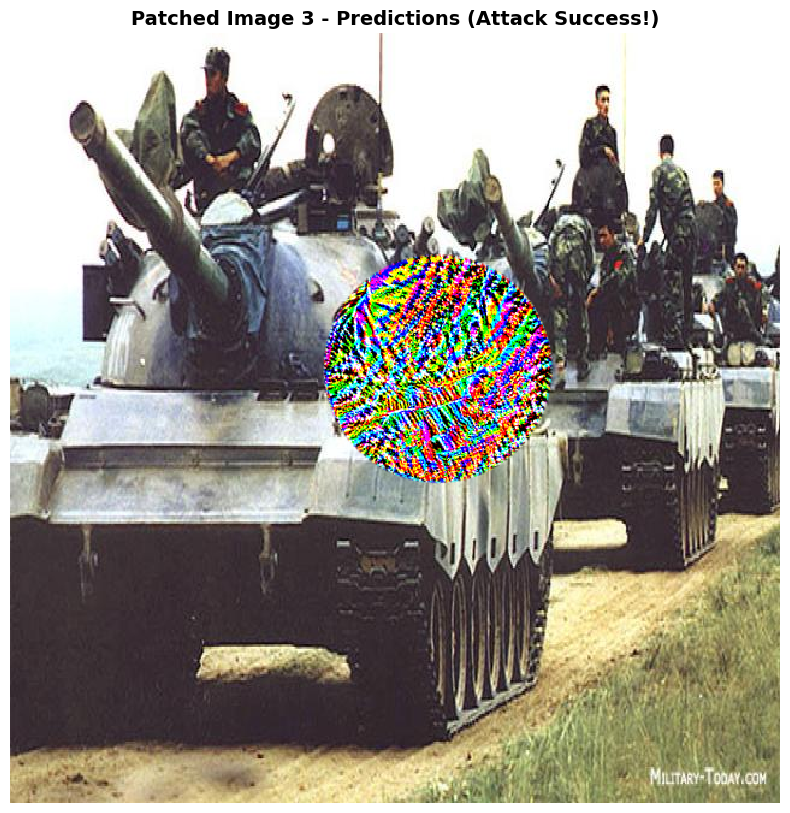

In [ ]:
# 패치 적용 결과 시각화
print("Visualizing patched image detections...")

for i in range(min(3, len(dets_patched))):
    preds_patched = extract_predictions(dets_patched[i], conf_thresh=0.5)
    img_display = patched_images[i].transpose(1, 2, 0).copy()
    plot_image_with_boxes(
        img=img_display,
        boxes=preds_patched[1],
        pred_cls=preds_patched[0],
        pred_scores=preds_patched[2],
        title=f"Patched Image {i+1} - Predictions (Attack Success!)"
    )

## 11. 공격 성공률 분석

In [ ]:
# 공격 효과 메트릭 계산
def calculate_attack_success(original_dets, patched_dets, conf_thresh=0.5):
    total_original = 0
    total_patched = 0
    
    for orig, patched in zip(original_dets, patched_dets):
        orig_boxes = [s for s in orig['scores'] if s > conf_thresh]
        patched_boxes = [s for s in patched['scores'] if s > conf_thresh]
        
        total_original += len(orig_boxes)
        total_patched += len(patched_boxes)
    
    reduction_rate = (total_original - total_patched) / total_original * 100 if total_original > 0 else 0
    
    return {
        'total_original': total_original,
        'total_patched': total_patched,
        'reduction_rate': reduction_rate
    }

metrics = calculate_attack_success(dets, dets_patched)

print("\n" + "="*60)
print("ADVERSARIAL PATCH ATTACK RESULTS")
print("="*60)
print(f"Original detections: {metrics['total_original']}")
print(f"Patched detections: {metrics['total_patched']}")
print(f"Detection reduction rate: {metrics['reduction_rate']:.1f}%")
print("="*60)


ADVERSARIAL PATCH ATTACK RESULTS
Original detections: 10
Patched detections: 8
Detection reduction rate: 20.0%


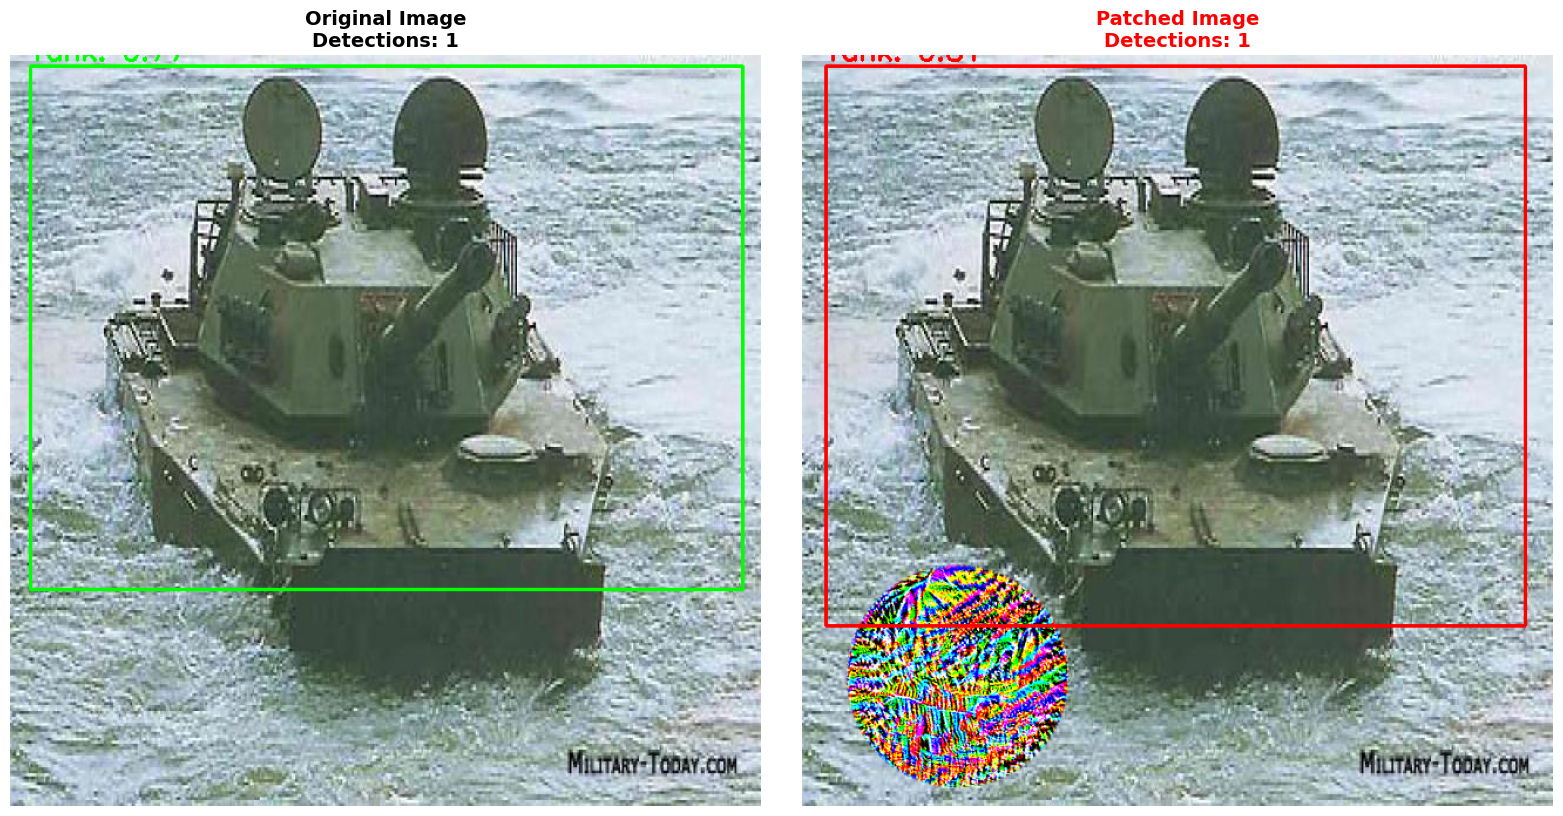

In [ ]:
# 시각적 비교 (원본 vs 패치)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 원본
img_idx = 0
img_orig = tank_images[img_idx].transpose(1, 2, 0).copy()
preds_orig = extract_predictions(dets[img_idx], conf_thresh=0.5)

for box, label, score in zip(preds_orig[1], preds_orig[0], preds_orig[2]):
    cv2.rectangle(img_orig, (int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1])),
                  color=(0, 255, 0), thickness=2)
    cv2.putText(img_orig, f"{label}: {score:.2f}", (int(box[0][0]), int(box[0][1]) - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), thickness=2)

axes[0].imshow(img_orig.astype(np.uint8))
axes[0].set_title(f"Original Image\nDetections: {len(preds_orig[0])}", fontsize=14, weight='bold')
axes[0].axis('off')

# 패치 적용
img_patched = patched_images[img_idx].transpose(1, 2, 0).copy()
preds_patched = extract_predictions(dets_patched[img_idx], conf_thresh=0.5)

for box, label, score in zip(preds_patched[1], preds_patched[0], preds_patched[2]):
    cv2.rectangle(img_patched, (int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1])),
                  color=(255, 0, 0), thickness=2)
    cv2.putText(img_patched, f"{label}: {score:.2f}", (int(box[0][0]), int(box[0][1]) - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), thickness=2)

axes[1].imshow(img_patched.astype(np.uint8))
axes[1].set_title(f"Patched Image\nDetections: {len(preds_patched[0])}", fontsize=14, weight='bold', color='red')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 12. 패치 저장

In [ ]:
# 생성된 패치 저장# Use relative path from project rootoutput_dir = PROJECT_ROOT / "art_training" / "attacks" / "adversarial_patches"output_dir.mkdir(parents=True, exist_ok=True)# 패치 저장 (numpy)patch_path = output_dir / "tank_adversarial_patch.npy"np.save(patch_path, patch)print(f"Adversarial patch saved to: {patch_path}")# 패치 이미지 저장 (PNG)patch_img_path = output_dir / "tank_adversarial_patch.png"patch_img = (patch * patch_mask).transpose(1, 2, 0).astype(np.uint8)Image.fromarray(patch_img).save(patch_img_path)print(f"Patch image saved to: {patch_img_path}")

Adversarial patch saved to: /home/jaehyun/yolo_train/art_training/attacks/adversarial_patches/tank_adversarial_patch.npy
Patch image saved to: /home/jaehyun/yolo_train/art_training/attacks/adversarial_patches/tank_adversarial_patch.png


## 결론

이 실습에서는:
1. YOLOv8 모델을 PyTorchYoloLossWrapper로 래핑
2. 커스텀 Tank 데이터셋 로드
3. AdversarialPatchPyTorch를 사용한 적대적 패치 생성
4. 패치 적용 후 탐지 성능 저하 확인

**핵심 결과:**
- 적대적 패치가 물리적 세계에서도 적용 가능
- 작은 패치로도 탐지 시스템 회피 가능
- 방어 기법 개발의 중요성 강조